In [1]:
import sys
import os
import copy

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import torch
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays


In [2]:
from wisp.framework import WispState
from kaolin.render.camera import Camera, blender_coords
from inerf_utils import *
from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    return pipeline
    # return pipeline

def gen_camera(pose, focal, w, h, far, extra_args):
    view_matrix = torch.zeros_like(pose)
    view_matrix[:3, :3] = pose[:3, :3].T
    view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    view_matrix[3, 3] = 1.0

    x0 = 0.0
    y0 = 0.0
    print(view_matrix)
    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )
    camera.change_coordinate_system(blender_coords())
    print(camera.extrinsics.parameters().reshape((4,4)))
    # mask = camera.extrinsics.gradient_mask('t')
    # camera.extrinsics.parameters.register_hook(lambda grad: grad * mask.float())
    
    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

# def gen_rays(pose, focal, w, h, far):
#     ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
#     rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
#     # rays = Rays.stack(rays).to(dtype=torch.float)
    
#     return camera, rays

In [3]:
render_batch = 40000
def render_pipeline(pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(render_batch):
        # print("haha")
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx)
    return rb

In [4]:
W, H = 800, 800
fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 5e-3,
  'epochs': 200
}


In [5]:

# def max_unc_sampling(pipelines, rays:Rays, patch_size=5):

#     rays = rays.reshape((W, H, -1))
#     # sampled_rays = Rays(torch.empty((0,3)), torch.empty((0, 3)), dist_min=extra_args['z_near'], dist_max=extra_args['z_far'])
#     total_loss = 0
#     for j in range(0, H, patch_size):
#         for i in range(0, W, patch_size):
#             # with torch.no_grad():
            
#             patch_rays = rays[i:(i+patch_size), j:(j+patch_size)]
#             patch_rays = patch_rays.reshape((patch_size**2, -1))

#             all_rgbs = torch.zeros((len(pipelines), patch_size*patch_size, 3), dtype=float)
#             for i, pipeline in enumerate(pipelines):
#                 rb = render_pipeline(pipeline, patch_rays, None)
#                 all_rgbs[i,:,:] = rb.rgb

#             unc_loss = 1-torch.mean(torch.var(all_rgbs, axis = 0))
#             total_loss += unc_loss
#             unc_loss.backward()

#             # # print(all_rgbs)
#             # # print(unc_loss)
#             # # print(torch.max(unc_loss))
#             # max_unc = torch.max(unc_loss)
#             # ind = torch.argmax(unc_loss)
#             # # print(max_unc - torch.mean(unc_loss))
#             # max_unc_ray = patch_rays[ind:ind+1]
#             # # print(sampled_rays, max_unc_ray.to('cpu'))
#             # sampled_rays = Rays.cat([sampled_rays, max_unc_ray.to('cpu')])
#             # del(all_rgbs)
#     # print(sampled_rays)
#     print(total_loss)
#     # return sampled_rays
            
            

def batch_backwards(pipelines, rays:Rays, batch_size=4000):

    total_loss = 0
    
    for patch_rays in rays.split(batch_size):
            all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
            for i, pipeline in enumerate(pipelines):
                rb = render_pipeline(pipeline, patch_rays, None)
                all_rgbs[i,:,:] = rb.rgb

            unc_loss = 1-torch.mean(torch.var(all_rgbs, axis = 0))
            total_loss += unc_loss.item()
            unc_loss.backward(retain_graph=True)
    print(total_loss)
    return total_loss
            


def batch_backwards2(pipelines, camera, batch_size=4000):

    total_loss = 0
    patch = 0
    while True:
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        all_patch_rays = rays.split(batch_size)
        if len(all_patch_rays) == patch:
            break
        patch_rays = all_patch_rays[patch]

        all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
        for i, pipeline in enumerate(pipelines):
            rb = render_pipeline(pipeline, patch_rays, None)
            all_rgbs[i,:,:] = rb.rgb

        unc_loss = -torch.mean(torch.var(all_rgbs, axis = 0))
        total_loss += unc_loss.item()
        unc_loss.backward()
        patch += 1
    print(total_loss)
    return total_loss
            

In [6]:
def get_image(cam, pipeline):
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = render_pipeline(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    # v = np.concatenate([rgb, alpha], axis=2)

    # return v
    return rgb, alpha

In [7]:
argv_base = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=path_to_model',
    '--valid-only'
]

In [8]:
argv_base

['--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=path_to_model',
 '--valid-only']

In [9]:
sys.argv

['/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/ipykernel_launcher.py',
 '--ip=127.0.0.1',
 '--stdin=9003',
 '--control=9001',
 '--hb=9000',
 '--Session.signature_scheme="hmac-sha256"',
 '--Session.key=b"d7cad917-cf7c-4fec-b5db-f0975c82dffb"',
 '--shell=9002',
 '--transport="tcp"',
 '--iopub=9004',
 '--f=/home/saptarshi/.local/share/jupyter/runtime/kernel-v2-26970701L5yuXceiWOw.json']

In [10]:
model_name = "cheezit_single_side_env2_nobg_sam_scale10"
root_dir = '/home/saptarshi/dev/kaolin-wisp/_results_new/' + model_name + '/'

pipelines = []
for i in range(1,6):
    model_dir = os.path.join(root_dir, f"model_{i}")
    model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")
    print(model_path)
    sys.argv[1:] = argv_base
    sys.argv[2] = sys.argv[2].replace("path_to_model", model_path)
    print(sys.argv[2])
    args, args_dict = parse_args()
    pipeline = make_model(
        args, args_dict, extra_args, None, None)
    pipelines.append(pipeline)

/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/20230424-183933/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/202304

In [16]:
initial_pose = torch.tensor( [
    [
        -0.9995014259114849,
        0.008853261731609602,
        0.030307084281071314,
        0.012122826827879013
    ],
    [
        0.03157371693209943,
        0.28025993087038786,
        0.9594047485538192,
        0.3837618990282312
    ],
    [
        -9.43488636082214e-18,
        0.9598833215059198,
        -0.280399730910646,
        -0.14598789445406454
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
])

cur_pose = torch.tensor([
    [
        -1.0, 
        -2.823936947407328e-17, 
        5.340285413173258e-16, 
        2.4463562574074363e-17
    ], 
    [
        3.5457582038357597e-16, 
        -0.04896000828076464, 
        0.9988007396819185, 
        0.3995202958290813
    ], 
    [
        -1.089239719165523e-17, 
        0.9988007396819186, 
        0.04896000828076479, 
        -0.08590599579648245
    ], 
    [
        0.0, 
        0.0, 
        0.0, 
        1.0
    ]
])

initial_pose[..., :3, 3] *= 10/1.25
cur_pose[..., :3, 3] *= 10/1.25

# initial_pose = cur_pose

In [17]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
camera.switch_backend('matrix_6dof_rotation')
camera.extrinsics.requires_grad = True

cur_cam = gen_camera(torch.clone(cur_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
cur_cam.switch_backend('matrix_6dof_rotation')
current_pose = cur_cam.extrinsics.parameters().clone()
current_pose_named = cur_cam.extrinsics.named_params()

tensor([[-9.9950e-01,  3.1574e-02, -9.4349e-18, -5.9605e-08],
        [ 8.8533e-03,  2.8026e-01,  9.5988e-01,  2.5977e-01],
        [ 3.0307e-02,  9.5940e-01, -2.8040e-01, -3.2759e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-9.9950e-01, -9.4349e-18, -3.1574e-02, -5.9605e-08],
        [ 8.8533e-03,  9.5988e-01, -2.8026e-01,  2.5977e-01],
        [ 3.0307e-02, -2.8040e-01, -9.5940e-01, -3.2759e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[-1.0000e+00,  3.5458e-16, -1.0892e-17, -9.4506e-16],
        [-2.8239e-17, -4.8960e-02,  9.9880e-01,  8.4291e-01],
        [ 5.3403e-16,  9.9880e-01,  4.8960e-02, -3.1587e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00, -1.0892e-17, -3.5458e-16, -9.4506e-16],
        [-2.8239e-17,  9.9880e-01,  4.8960e-02,  8.4291e-01],
        [ 5.3403e-16,  4.8960e-02, -9.9880e-01, -3.1587e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1

In [18]:
(torch.inverse(cur_pose))

tensor([[-1.0000e+00,  5.3477e-16, -2.0595e-18, -1.5149e-15],
        [-2.8239e-17, -4.8960e-02,  9.9880e-01,  8.4291e-01],
        [ 3.5362e-16,  9.9880e-01,  4.8960e-02, -3.1587e+00],
        [-6.6174e-24,  1.8626e-08, -2.3283e-10,  1.0000e+00]])

In [19]:
# camera.extrinsics.requires_grad = False
camera.extrinsics._backend.params

tensor([[-9.9950e-01, -9.4349e-18, -3.1574e-02,  8.8533e-03,  9.5988e-01,
         -2.8026e-01, -5.9605e-08,  2.5977e-01, -3.2759e+00]], device='cuda:0',
       requires_grad=True)

In [20]:
# optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=extra_args['lrate'])
optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=extra_args['lrate'])


In [21]:
current_pose

tensor([[-1.0000e+00, -1.0892e-17, -3.5458e-16, -2.8239e-17,  9.9880e-01,
          4.8960e-02, -9.4506e-16,  8.4291e-01, -3.1587e+00]], device='cuda:0')

In [22]:
initial_pose

tensor([[-9.9950e-01,  8.8533e-03,  3.0307e-02,  9.6983e-02],
        [ 3.1574e-02,  2.8026e-01,  9.5940e-01,  3.0701e+00],
        [-9.4349e-18,  9.5988e-01, -2.8040e-01, -1.1679e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


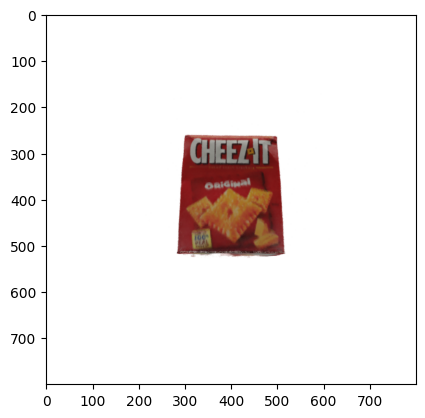

In [23]:
plt.imshow(get_image(camera, pipeline=pipelines[0])[0])
plt.show()

In [24]:
import cv2
from IPython.display import Video
imgs = []
# min_loss = 100
# min_params = None
print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
for ep in range(extra_args['epochs']):
    optimizer.zero_grad()
    rays = gen_rays_only(camera)
    rays = rays.reshape((rays.shape[0]**2, -1))
    cur_loss = batch_backwards(pipelines, rays, 40000)
    # cur_loss = batch_backwards2(pipelines, camera, 40000)
    # if cur_loss < min_loss:
    #     min_loss = cur_loss
    #     min_params = camera.extrinsics._backend.params

    optimizer.step()
    img = get_image(camera, pipeline=pipelines[0])[0]
    imgs.append(img)
#     # del(all_rgbs)
#     del(unc_loss)
#     del(dist_loss)
    # print(current_pose, camera.extrinsics.parameters())
    # print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
    # print(camera.intrinsics.named_params())
    # plt.imshow(get_image(camera, pipeline=pipelines[0])[0])
    # plt.show()




tensor([-9.4506e-16,  8.4291e-01, -3.1587e+00], device='cuda:0') tensor([-5.9605e-08,  2.5977e-01, -3.2759e+00], device='cuda:0',
       grad_fn=<IndexBackward0>)
15.99692412657007
15.99675604884497
15.996599633079141
15.996382190553007
15.996213938383358
15.996009226595705
15.99582489909097
15.995658947652473
15.995461315673062
15.995277933312419
15.99511526491234
15.994931904970839
15.994773654049354
15.994649807355113
15.994491137749092
15.994370958580733
15.994251170541514
15.994185297700438
15.99407377156294
15.994024155299417
15.993998183757812
15.993919128625972
15.99393894839785
15.993959486333413
15.993951089000905
15.993973624489191
15.993969547570098
15.994009887328021
15.994043919484655
15.994083027477577
15.994173231224988
15.994183802161988
15.994258106786287
15.994257175190583
15.994310686852302
15.994301860927411
15.994337784622495
15.994326648645664
15.994312131943
15.994249728870875
15.99423267799696
15.994145555137617
15.994044714228888
15.99395369501066
15.993812934

In [22]:
camera.extrinsics.requires_grad = False
print(camera.extrinsics.parameters())
camera.extrinsics.switch_backend("matrix_se3")
print(camera.extrinsics.parameters().reshape((4, 4)))
camera.extrinsics.switch_backend("matrix_6dof_rotation")
# plt.imshow(get_image(camera, pipeline=pipelines[0])[0])
# plt.show()

tensor([[-0.7817,  0.2179, -0.2123, -0.2192,  0.5088,  0.8930, -0.1709,  0.7563,
         -2.8435]], device='cuda:0')
tensor([[-0.9319,  0.2598, -0.2530, -0.1709],
        [-0.1112,  0.4594,  0.8812,  0.7563],
        [ 0.3452,  0.8494, -0.3992, -2.8435],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


In [23]:
def batch_loss(rays, pipelines, batch_size):
    total_loss = 0
    for patch_rays in rays.split(batch_size):
            all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
            for i, pipeline in enumerate(pipelines):
                rb = render_pipeline(pipeline, patch_rays, None)
                all_rgbs[i,:,:] = rb.rgb

            unc_loss = -torch.mean(torch.var(all_rgbs, axis = 0))
            total_loss += unc_loss.item()
    print(total_loss)
    return total_loss
            



In [27]:
import copy
def loss_off(camera, off_x, off_y, off_z):
    cam2 = copy.deepcopy(camera)
    # print(cam2.extrinsics._backend.params)
    cam2.extrinsics._backend.params[0,6] += off_x
    cam2.extrinsics._backend.params[0,7] += off_y
    cam2.extrinsics._backend.params[0,8] += off_z
    # print(cam2.extrinsics._backend.params)
    # plt.imshow(get_image(cam2, pipeline=pipelines[0])[0])
    # plt.show()
    rays = gen_rays_only(cam2)
    rays = rays.reshape((rays.shape[0]**2, -1))
    return batch_loss(rays, pipelines, 640000)
    

In [28]:
import plotly.express as px
xs = torch.linspace(-10, 10, 100)
ys = [loss_off(camera, x, 0, 0) for x in xs]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [74]:
fig = px.line(x=xs, y=ys)
fig

In [ ]:
fig = px.line(x=xs, y=ys)
fig

In [ ]:
fig = px.line(x=xs, y=ys)
fig

In [ ]:
# # print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
# import cv2
# from IPython.display import Video

# out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, (200,200))
# imgs = []

# # for ep in range(extra_args['epochs']):
# for ep in range(200):
#     optimizer.zero_grad()
#     rays = gen_rays_only(camera)
#     rays = rays.reshape((rays.shape[0]**2, -1))
    
#     # all_rgbs = torch.zeros((len(pipelines), W*H, 3), dtype=float)
#     all_rgbs = torch.zeros((len(pipelines), W*H, 3), dtype=float)


#     for i, pipeline in enumerate(pipelines):
#         # rb = render_pipeline(pipeline, rays, None)
#         rb = pipeline(rays)
#         # print(rb.rgb.shape)
#         all_rgbs[i,:,:] = rb.rgb
#     # print(all_rgbs)


#     # var = torch.var(all_rgbs, axis = 0)
#     # std = torch.sqrt(torch.mean(var, axis = -1))
#     # std = torch.mean(var, axis = -1)
#     # std.retain_grad()
#     # std.register_hook(lambda x : print('std', x.mean()))
#     # unc_loss = math.sqrt(3)-torch.mean(torch.sqrt(torch.sum(torch.var(all_rgbs, axis = 0), axis = -1)))

#     # dist_loss = torch.mean((current_pose - camera.extrinsics.parameters())**2)
#     # flip_loss = 


#     unc_loss = 1-torch.mean(torch.var(all_rgbs, axis = 0))
#     dist_loss = torch.mean((current_pose_named[0]['t'] - camera.extrinsics.t)**2)

#     loss = unc_loss 
#     # print(unc_loss, dist_loss, loss)

#     loss.backward()
#     optimizer.step()
#     # del(all_rgbs)
#     del(unc_loss)
#     del(dist_loss)

#     print(ep, loss.item())
#     # print(current_pose, camera.extrinsics.parameters())
#     # print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
#     # print(camera.intrinsics.named_params())
#     img = get_image(camera, pipeline=pipelines[0])[0]
#     imgs.append(img)
#     # plt.imshow(img)
#     # img = (img * 255).astype(np.uint8)
#     # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     # out.write(img)
#     # plt.show()



In [25]:
out = cv2.VideoWriter('output_video7.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, (800,800))
for i in range(len(imgs)):
    img = imgs[i]
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    out.write(img)

: 

In [ ]:
cv2.imwrite('temp.png', img)

True

In [ ]:
imgs[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [ ]:
torch.isnan(var[:,2])

NameError: name 'var' is not defined

In [ ]:
torch.mean((current_pose - camera.extrinsics.parameters())**2)

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
camera.extrinsics.named_params()[0]

{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
        grad_fn=<IndexBackward0>),
 't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
camera.intrinsics.named_params()

[{'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

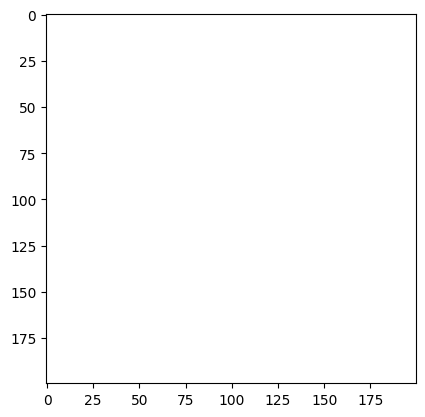

In [ ]:
plt.imshow(get_image(camera, pipeline=pipelines[0])[0])


In [ ]:
torch.tensor([[-1.0, -2.823936947407328e-17, 5.340285413173258e-16, 2.4463562574074363e-17], [3.5457582038357597e-16, -0.04896000828076464, 0.9988007396819185, 0.3995202958290813], [-1.089239719165523e-17, 0.9988007396819186, 0.04896000828076479, -0.08590599579648245], [0.0, 0.0, 0.0, 1.0]])

tensor([[-1.0000e+00, -2.8239e-17,  5.3403e-16,  2.4464e-17],
        [ 3.5458e-16, -4.8960e-02,  9.9880e-01,  3.9952e-01],
        [-1.0892e-17,  9.9880e-01,  4.8960e-02, -8.5906e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
gen_rays_only(camera)

Rays(origins=tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, n

In [ ]:
camera.view_projection_matrix()

tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]], device='cuda:0', grad_fn=<BmmBackward0>)

In [ ]:
camera.named_params()

[{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
         grad_fn=<IndexBackward0>),
  't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>),
  'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

In [ ]:
initial_pose

tensor([[-1.0000e+00, -4.6265e-16,  4.7207e-16,  1.4103e-16],
        [ 5.3111e-16, -6.9423e-01,  7.1976e-01,  2.3032e+00],
        [-1.3052e-16,  7.1976e-01,  6.9423e-01,  1.3776e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
torch.inverse(camera.extrinsics.parameters().reshape((4,4)))

RuntimeError: shape '[4, 4]' is invalid for input of size 9

In [ ]:
camera.extrinsics.named_params()

In [ ]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)


In [ ]:
camera.extrinsics.t

tensor([[[-1.1280e-15],
         [ 7.5927e-01],
         [-3.2677e+00]]], device='cuda:0', grad_fn=<SliceBackward0>)